In [1]:
# python 3.6.4

import warnings
warnings.filterwarnings('ignore')
#import timeit
import json
import os
import numpy

from my_callback import MyCallback

Using TensorFlow backend.


In [2]:
import gym.spaces
import numpy
import pandas
import math


class Game(gym.core.Env):
    metadata = {'render.modes': ['human', 'rgb_array']}
    def __init__(self, data, columns):
        self.data = data
        self.columns = columns
        self.code_dict = {"1": "1"} # code_id: code
        self.action_space = gym.spaces.Discrete(1+2*len(self.code_dict)) # stay + {long|short}*n_code
        low_bound = numpy.array([0]*len(columns))
        high_bound = numpy.array([9999]*len(columns))
        self.observation_space = gym.spaces.Box(
            low=low_bound, high=high_bound)
        self.time = 0
        self.profit = 0
        
    def set_data(self, df):
        self.data = df

    def step(self, action):
        time = self.time
        profit, reward = self.calc_profit(action, time)
        self.time += 1
        self.profit += profit
        done = self.time == (len(self.data) - 1)
        info = {}
        observation = self.observation(time+1)
        return observation, reward, done, info

    def observation(self, time):
        return numpy.array([self.data[col][time] for col in self.columns])

    def calc_profit(self, action, time):
        # Returns: profit, reward
        if action == 0:
            return 0, 0
        elif action % 2 == 1:
            position = 1 # long
        elif action % 2 == 0:
            position = -1 # short
            
        code_id = int((action + 1) / 2)
        code = self.code_dict[str(code_id)]
        
        open_2tomorrow = self.data["{}_open_2tomorrow".format(code)][time]
        open_1tomorrow = self.data["{}_open_tomorrow".format(code)][time]
        
        profit = position * (open_2tomorrow - open_1tomorrow) / open_1tomorrow
        if profit < 0:
            return profit, profit * 1.3255 # 損益にペナルティ
        return profit, profit

    def reset(self):
        self.time = 0
        self.profit = 0
        return self.observation(0)

    def render(self, mode):
        pass

    def close(self):
        pass

    def seed(self):
        pass

In [3]:
from keras.models import Sequential, Model
from keras.layers import (
    Dense,
    Activation,
    Flatten,
    Input,
    concatenate,
    Dropout,
    Embedding,
    Reshape,
    BatchNormalization
)

class Network(object):
    def __init__(self):
        self.model = None

    def sample_model(self, observation_space):
        model = Sequential()
        model.add(Flatten(input_shape=(1,) + observation_space.shape))
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(Dense(env.action_space.n))
        model.add(Activation('linear'))        
        self.model = model
        return model        
    
    def from_json(self, file_path):
        pass
    
    def to_json(self, output_path):
        pass


In [4]:
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
from keras.optimizers import Adam

def agent(model, n_action):
    memory = SequentialMemory(limit=50000, window_length=1)
    policy = EpsGreedyQPolicy(eps=0.1)
    dqn_agent = DQNAgent(model=model, nb_actions=n_action,
                         memory=memory, nb_steps_warmup=100,
                         target_model_update=1e-2, policy=policy)
    dqn_agent.compile(Adam(lr=1e-3), metrics=['mae'])
    return dqn_agent

In [5]:
import pandas
import numpy

df = pandas.read_csv("data/train_data.csv")
n = int(len(df) * 0.8)
train, test = df[0:n], df[n:].reset_index(drop=True)

In [6]:
df.columns

Index(['date', 'feature_1', '1_open_tomorrow', '1_open_2tomorrow'], dtype='object')

In [7]:
columns = list(df.columns[1:-2]) # ["r"] dateと1_open_tomorrow, 1_open_2_tomorrowを除く
env = Game(train, columns)
network = Network()
model = network.sample_model(env.observation_space)
agent_v6 = agent(model, env.action_space.n)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [8]:
callback= MyCallback("tmp")
agent_v6.fit(env, nb_steps=10000, visualize=False,
                  verbose=2, callbacks=[callback])

Training for 10000 steps ...
Training for 10000 steps ...
 2211/10000: episode: 1, duration: 7.274s, episode steps: 2211, steps per second: 304, episode reward: -4.018, mean reward: -0.002 [-0.155, 0.098], mean action: 1.822 [0.000, 2.000], loss: 3150.662079, mean_absolute_error: 93.531051, mean_q: 128.961893
The reward is higher than the best one, saving checkpoint weights
 2211/10000: episode: 1, duration: 7.334s, episode steps: 2211, steps per second: 301, episode reward: -4.018, mean reward: -0.002 [-0.155, 0.098], mean action: 1.822 [0.000, 2.000], mean observation: 1.000 [1.000, 1.000], loss: 3150.662079, mean_absolute_error: 93.531051, mean_q: 128.961893
 4422/10000: episode: 2, duration: 6.550s, episode steps: 2211, steps per second: 338, episode reward: -3.522, mean reward: -0.002 [-0.155, 0.098], mean action: 1.887 [0.000, 2.000], loss: 40795.042969, mean_absolute_error: 516.701477, mean_q: 771.850891
The reward is higher than the best one, saving checkpoint weights
 4422/100

In [9]:
agent_v6.load_weights("tmp/best_weight.hdf5")

In [10]:
def _generate_profit(env, test, agent_v6):
    env.set_data(test)
    for i, row in env.data.iterrows():
        obs = env.observation(i)
        action = agent_v6.forward(obs)
        profit, reward = env.calc_profit(action, i)
        yield profit

In [11]:
test["profit"] = pandas.Series(list(_generate_profit(env, test, agent_v6)))

In [12]:
test["sum_profit"] = numpy.cumsum(test["profit"])

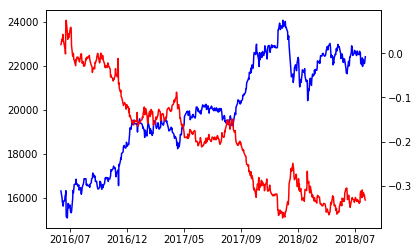

In [15]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
x = pandas.to_datetime(test["date"])
ax1.plot(x, test["1_open_tomorrow"], c="b")
ax2.plot(x, test["sum_profit"], c="r")
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y/%m"))
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y/%m"))
ax1.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(8))
ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(8))
plt.show()

In [14]:
plt.show()

In [ ]:
import to_gmail

In [ ]:
message = "test"
to_gmail.send(message)